In [1]:
import numpy as np
import numba as nb
from numba import config, njit, prange, threading_layer
from numba import int64, float32, uint8
from numba.typed import List
from tqdm.notebook import tqdm, trange
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib notebook

In [35]:
@njit
def check(lattice:np.ndarray, queue):  # obsolete
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    counter = 0
    
    xz, yz = np.where(lattice == 1)
    zlist = List()
    
    for i in range(len(xz)):
        zlist.append((xz[i], yz[i]))
    #zlist = np.transpose(np.array(np.where(lattice == 1)))
    
    for xyz in zlist:

        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0:
                counter = counter + 1
                if (xyz, xyn) not in queue:
                    print(xyz, xyn)
                    return False
                
    if counter == len(queue):
        return True
    else:
        print(counter, len(queue))
        return False
    
@njit
def update(lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float, v:float, u:float):    

    l_q = len(queue)
    l_s = len(human)
    l_z = len(zombie)
    
    if l_q == 0 and l_s*l_z == 0:
        return lattice, queue, human, zombie

    
    r = np.random.uniform(0, 1)
    
    if r < (b+k)*l_q/((b+k)*l_q + v*l_s + u*l_z):
        #print("bite or kill")
        
        lattice, queue, human, zombie = update_bk(lattice, queue, human, zombie, k, b)
        
    elif r < ((b+k)*l_q + v*l_s)/((b+k)*l_q + v*l_s + u*l_z):
        #print("human move")
        lattice, queue, human, zombie = update_hm(lattice, queue, human, zombie)
        
    else:
        #print("zombie move")
        lattice, queue, human, zombie = update_zm(lattice, queue, human, zombie)
        
        
    return lattice, queue, human, zombie

@njit 
def update_hm(lattice:np.ndarray, queue:list, human:list, zombie:list):
    
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)

    def get_p(xys):
        res = np.zeros(4, dtype = float32)
        scorem = np.zeros(4, dtype = int64)
        
        score = 0
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] != 1:
                score = score + 1
    
        
        i = 0
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 3:
                scorem[i] = 0 
                for xym in left(xyn), right(xyn), up(xyn), down(xyn):
                    if lattice[xym] != 1:
                        scorem[i] = scorem[i] + 1
            i = i + 1
            
        if score > np.max(scorem):
            return res
        else:
            for i in range(4):
                res[i] = max(scorem[i] - np.max(scorem) + 1, 0)
            return res
    
    ind = np.random.randint(len(human))
    
    xys = human[ind]
    assert(lattice[xys] == 0)
    
    p_dist = get_p(xys)
    
    if np.sum(p_dist) == 0:
        return lattice, queue, human, zombie
    
    r = np.random.uniform(0, 1)
    
    p_sum = np.cumsum(p_dist)/np.sum(p_dist)
    
    l_xyn = [left(xys), right(xys), up(xys), down(xys)]
    
    xyd = l_xyn[np.searchsorted(p_sum, r)]
    
    assert(lattice[xyd] == 3)
    
    for xyn in l_xyn:
        if lattice[xyn] == 1:
            queue.remove((xyn, xys))
            
    for xyn in left(xyd), right(xyd), up(xyd), down(xyd):
        if lattice[xyn] == 1:
            queue.append((xyn, xyd))
            
    lattice[xys] = 3
    lattice[xyd] = 0
    human[ind] = xyd
    
    sealed = lambda xyt, xyx: (lattice[left(xyt)] != 3 or left(xyt) == xyx) and (lattice[right(xyt)] != 3 or right(xyt) == xyx) and (lattice[up(xyt)] != 3 or up(xyt) == xyx) and (lattice[down(xyt)] != 3 or down(xyt) == xyx)
    
    for xyn in left(xyd), right(xyd), up(xyd), down(xyd):
        if xyn != xys and lattice[xyn] != 3:
            if sealed(xyn, xyd):
                if lattice[xyn] == 0:
                    human.remove(xyn)
                else:
                    assert(lattice[xyn] == 1)
                    zombie.remove(xyn)
                    
    for xyn in left(xys), right(xys), up(xys), down(xys):
        if xyn != xyd and lattice[xyn] != 3:
            if sealed(xyn, xys):
                if lattice[xyn] == 0:
                    human.append(xyn)
                else:
                    assert(lattice[xyn] == 1)
                    zombie.append(xyn)                
    
    return lattice, queue, human, zombie
    
@njit 
def update_zm(lattice:np.ndarray, queue:list, human:list, zombie:list):
        
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)

    def get_p(xyz):
        res = np.zeros(4, dtype = float32)
        
        i = 0
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 3:
                res[i] = 1.0
            else:
                res[i] = 0.0
            i = i + 1
        return res
    
    ind = np.random.randint(len(zombie))
    
    xyz = zombie[ind]
    assert(lattice[xyz] == 1)
    
    p_dist = get_p(xyz)
    
    if np.sum(p_dist) == 0:
        return lattice, queue, human, zombie
    
    r = np.random.uniform(0, 1)
    
    p_sum = np.cumsum(p_dist)/np.sum(p_dist)
    
    l_xyn = [left(xyz), right(xyz), up(xyz), down(xyz)]
    
    xyd = l_xyn[np.searchsorted(p_sum, r)]
    
    assert(lattice[xyd] == 3)
    
    for xyn in l_xyn:
        if lattice[xyn] == 0:
            queue.remove((xyz, xyn))
            
    for xyn in left(xyd), right(xyd), up(xyd), down(xyd):
        if lattice[xyn] == 0:
            queue.append((xyd, xyn))
            
    lattice[xyz] = 3
    lattice[xyd] = 1
    zombie[ind] = xyd
    
    sealed = lambda xyt, xyx: (lattice[left(xyt)] != 3 or left(xyt) == xyx) and (lattice[right(xyt)] != 3 or right(xyt) == xyx) and (lattice[up(xyt)] != 3 or up(xyt) == xyx) and (lattice[down(xyt)] != 3 or down(xyt) == xyx)
    
    for xyn in left(xyd), right(xyd), up(xyd), down(xyd):
        if xyn != xyz and lattice[xyn] != 3:
            if sealed(xyn, xyd):
                if lattice[xyn] == 0:
                    human.remove(xyn)
                else:
                    assert(lattice[xyn] == 1)
                    zombie.remove(xyn)
                    
    for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
        if xyn != xyd and lattice[xyn] != 3:
            if sealed(xyn, xyz):
                if lattice[xyn] == 0:
                    human.append(xyn)
                else:
                    assert(lattice[xyn] == 1)
                    zombie.append(xyn) 
    
    return lattice, queue, human, zombie
    
    

@njit
def update_bk(lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float):
    
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    sealed = lambda xyn: lattice[left(xyn)] != 3 and lattice[right(xyn)] != 3 and lattice[up(xyn)] != 3 and lattice[down(xyn)] != 3
    
    ind = np.random.randint(len(queue))

    r = np.random.uniform(0, 1)
    
    if r < b/(b + k):
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xys] = 1
        if not sealed(xys):
            human.remove(xys)
            zombie.append(xys)
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 0:
                queue.append((xys, xyn))
                
        
        if len(queue) == 0:
            return lattice, queue, human, zombie
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 1 and xyn != xyz:
                queue.remove((xyn, xys))
 
        

    else:
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xyz] = 3
        if not sealed(xyz):
            zombie.remove(xyz)
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0:
                if xyn not in human:
                    human.append(xyn)
            elif lattice[xyn] == 1:
                if xyn not in zombie:
                    zombie.append(xyn)
        
                
        if len(queue) == 0:
            return lattice, queue, human, zombie
        
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0 and xyn != xys:
                queue.remove((xyz, xyn))
               
    
    return lattice, queue, human, zombie


@njit
def init_lattice(L:int, xy0, sparsity):
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    lattice = np.zeros((L, L), dtype = int64)
    randmatx = np.random.uniform(0, 1, size = (L, L))
    lattice = np.where(randmatx < sparsity, 3, 0)  # don't mess up with count
    lattice[xy0] = 1
    
    queue = List()
    human = List()
    zombie = List()
    sealed = lambda xyn: lattice[left(xyn)] != 3 and lattice[right(xyn)] != 3 and lattice[up(xyn)] != 3 and lattice[down(xyn)] != 3
    
    for xyn in left(xy0), right(xy0), up(xy0), down(xy0):
        if lattice[xyn] == 0:
            queue.append((xy0, xyn))
            
    for i in range(L):
        for j in range(L):
            if lattice[i, j] == 0:
                if not sealed((i, j)):
                    human.append((i, j))
            elif lattice[i, j] == 1:
                if not sealed((i, j)):
                    zombie.append((i, j))
    
    return lattice, queue, human, zombie    


@njit
def init_lattice_(lattice:np.ndarray, queue:list, xy0): # obsolete
    
    L, _ = lattice.shape

    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    lattice[:, :] = 0
    randmatx = np.random.uniform(0, 1, size = (L, L))
    lattice = np.where(randmatx < sparsity, 3, 0)  # don't mess up with count
    lattice[xy0] = 1
    
    queue = List()
    human = List()
    zombie = List()
    
    for xyn in left(xy0), right(xy0), up(xy0), down(xy0):
        if lattice[xyn] == 0:
            queue.append((xy0, xyn))
            
    for i in range(L):
        for j in range(L):
            if lattice[i, j] == 0:
                human.append((i, j))
            elif lattice[i, j] == 1:
                zombie.append((i, j))

    
    return lattice, queue, human, zombie
    

@njit
def run_lattice_(nmax:int, lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float, v:float, u:float): 

    counter = 0    
    while (len(queue) + len(human)*len(zombie)) != 0 and counter < nmax:
        counter = counter + 1
        lattice, queue, human, zombie = update(lattice, queue, human, zombie, k, b, v, u)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
            
    return lattice, queue, human, zombie

@njit
def run_lattice_log_(nmax:int, lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float, v:float, u:float): 
    L1, L2 = lattice.shape
    log = np.zeros((nmax, L1, L2))
    counter = 0    
    while (len(queue) + len(human)*len(zombie)) != 0 and counter < nmax:
        counter = counter + 1
        lattice, queue, human, zombie = update(lattice, queue, human, zombie, k, b, v, u)
        log[counter] = lattice
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
            
    return log, queue, human, zombie

def run_lattice_log(nmax:int, lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float, v:float, u:float):
    start_time = time.time()
    log, queue, human, zombie = run_lattice_log_(nmax, lattice, queue, human, zombie, k, b, v, u)
    print(time.time() - start_time)
    
    return log, queue, human, zombie

def run_lattice(nmax:int, lattice:np.ndarray, queue:list, human:list, zombie:list, k:float, b:float, v:float, u:float):
    start_time = time.time()
    lattice, queue, human, zombie = run_lattice_(nmax, lattice, queue, human, zombie, k, b, v, u)
    print(time.time() - start_time)
    
    return lattice, queue, human, zombie

  
def run_check_lattice(L:int, xy0, k:float, b:float): # obsolete
    
    lattice, queue = init_lattice(L, xy0)
    counter = 0
    while len(queue) != 0:
        
        if check(lattice, queue) == False:
            print("error")
            break
           
        counter = counter + 1
        lattice, queue = update(lattice, queue, k, b)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
        
    return lattice, queue

config.THREADING_LAYER = 'threadsafe'
@njit(parallel = True)
def cluster_size(s_list:np.ndarray, lattice:np.ndarray, queue:list, alpha, sparsity):
    N = s_list.shape[0]    
    for i in prange(N):
        lattice, queue = init_lattice(1024, (512, 512), sparsity)
        lattice, queue = run_lattice_(lattice, queue, alpha, 1)
        s_list[i] = np.count_nonzero(lattice == 1) + np.count_nonzero(lattice == 2)
    return s_list

@njit
def nb_seed(seed):
    np.random.seed(seed)

In [36]:
seed = np.random.randint(1000000)
seed = 524149
nb_seed(seed)
lattice, queue, human, zombie = init_lattice(128, (64, 64), 0.4)
lattice, queue, human, zombie = run_lattice(15000000, lattice, queue, human, zombie, 0.4, 1, 100, 200)

69.00770092010498


<IPython.core.display.Javascript object>


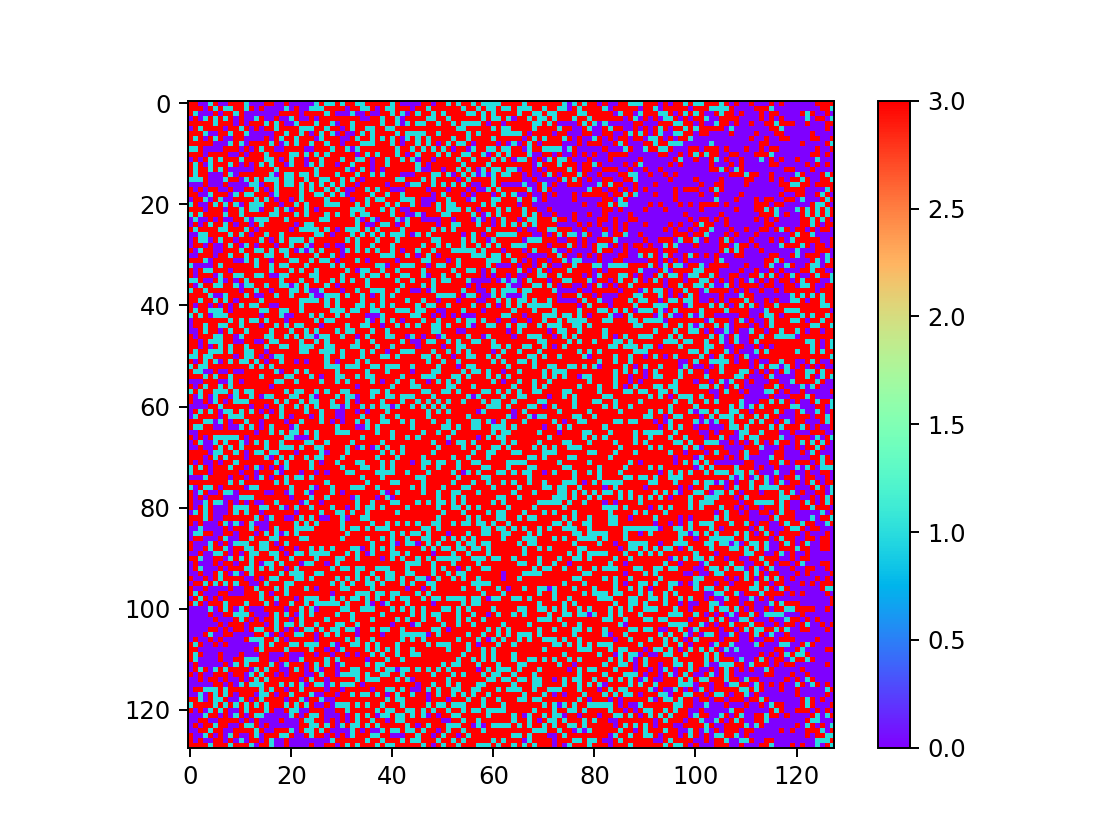

In [37]:
plt.imshow(lattice, vmin = 0, vmax = 3, cmap = 'rainbow')
plt.colorbar()

In [40]:
seed = np.random.randint(1000000)
seed = 524148
nb_seed(seed)
lattice, queue, human, zombie = init_lattice(128, (64, 64), 0.1)
lattice, queue, human, zombie = run_lattice(15000000, lattice, queue, human, zombie, 0.4, 1, 100, 200)

112.11604475975037


<IPython.core.display.Javascript object>


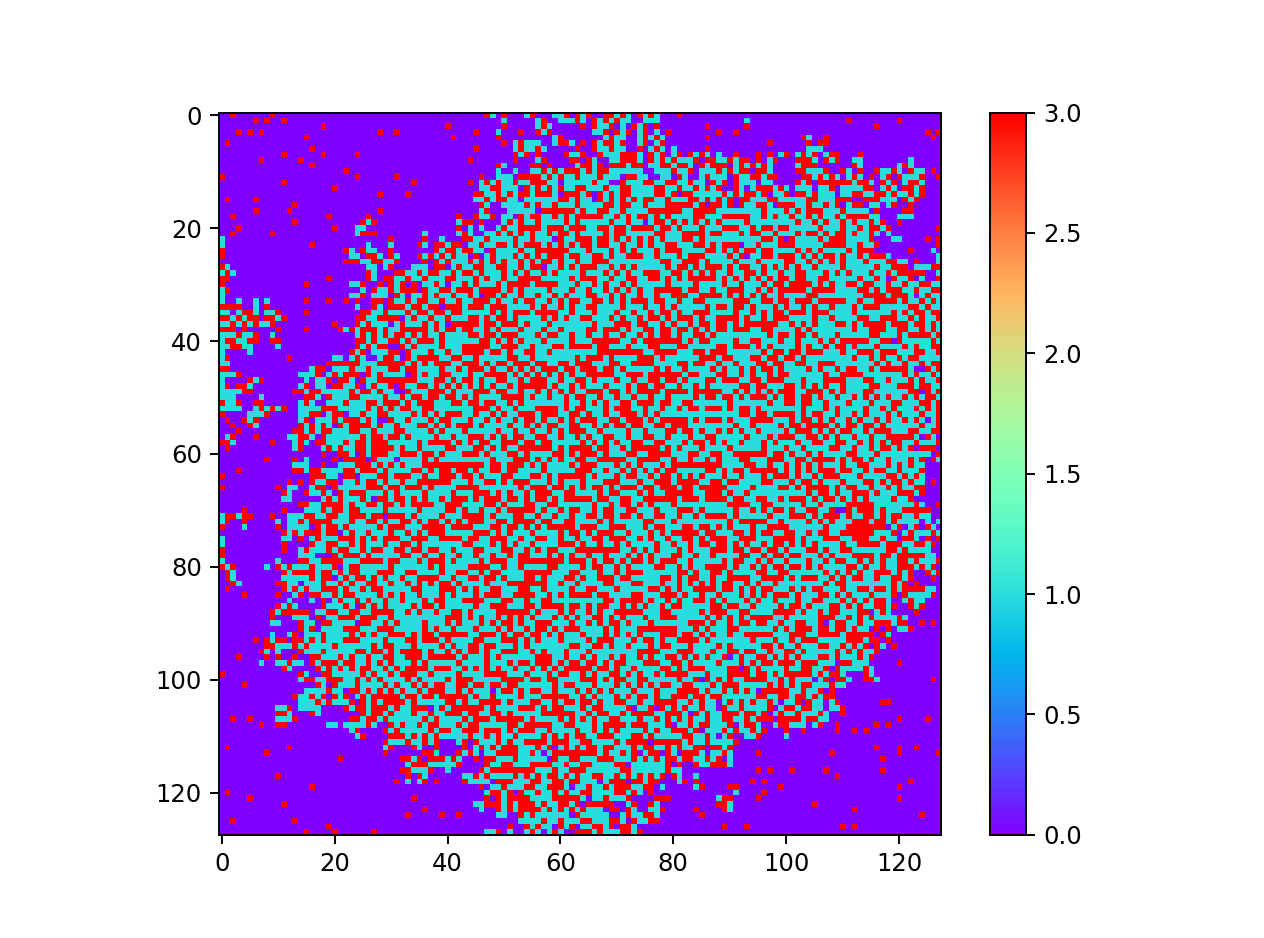

In [41]:
plt.imshow(lattice, vmin = 0, vmax = 3, cmap = 'rainbow')
plt.colorbar()